Here, we demonstrate using SEACells functions to aggregate the transcriptomes of cells and calculate the transcriptomic expression profiles of metacells.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc

import SEACells as sea 

import datatable as dt


/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
adata = sc.read_h5ad('GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')

In [3]:
A=dt.fread(f'multiome_neurips21_weights.csv.gz', header=True).to_pandas().set_index('index')
A.columns = [f'MC_{i}' for i in A.columns]

metacells = A.idxmax(axis=1)

In [4]:
adata = adata[metacells.index.tolist()]
adata.obs['metacells'] = metacells[adata.obs_names]

/tmp/ipykernel_710345/2614914728.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['metacells'] = metacells[adata.obs_names]


In [5]:
adata_metacells = sea.core.summarize_by_SEACell(adata, SEACells_label='metacells', celltype_label='cell_type', summarize_layer='counts')
adata_metacells.obs['cell_type'] = adata.obs.groupby('metacells').apply(
    lambda x: x['cell_type'].mode().iloc[0]
    ).loc[adata_metacells.obs_names]

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:06<00:00, 78.45it/s]


Cell type purity failed with Exception 'SEACell'


/tmp/ipykernel_710345/25095446.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adata_metacells.obs['cell_type'] = adata.obs.groupby('metacells').apply(


In [6]:
adata_metacells.X = adata_metacells.layers['raw'].copy()

sc.pp.normalize_total(adata_metacells, target_sum=1e6)
sc.pp.log1p(adata_metacells)
sc.pp.highly_variable_genes(adata_metacells, n_top_genes=3000, inplace=True)

sc.tl.pca(adata_metacells, use_highly_variable=True)
sc.pp.neighbors(adata_metacells, use_rep='X_pca')
sc.tl.umap(adata_metacells)

/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


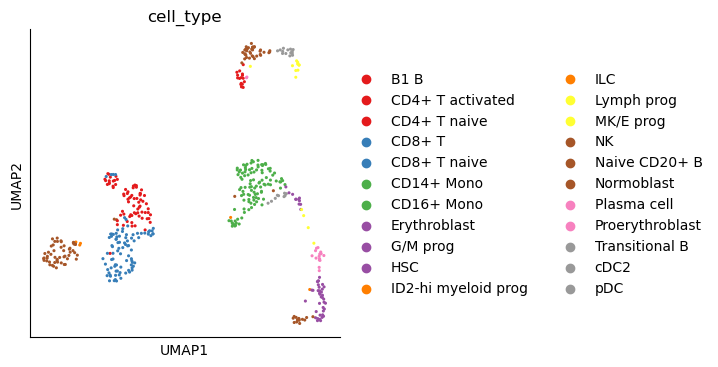

In [7]:
sc.pl.umap(adata_metacells, color='cell_type', palette='Set1', s=20)
